<h1 align="center"><font size="5">Classification with Python</font></h1>

<h1 align="center"><font size="5">Loan default prediction with KNN, Decision Trees, SVM, Logistic Regression</font></h1>
 

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-12-29 07:44:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22,56K  --.-KB/s    in 0,1s    

2020-12-29 07:44:17 (234 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#uncomment this line if needed
#!conda install -c anaconda seaborn -y

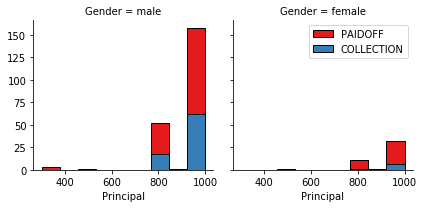

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

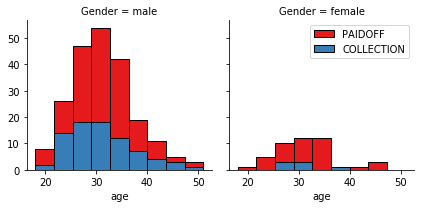

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

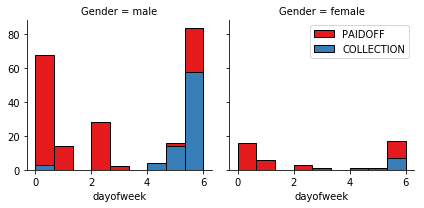

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y = df['loan_status'].values
y[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

For all of them we use 10-fold cross validation, measuring the accuracy, f1-score and jaccard score.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score as jaccard_score
#from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

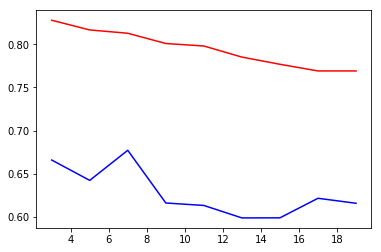

In [21]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

test_ACC, train_ACC = [], []
#test_F1, train_F1 = [], []
#test_J, train_J = [], []
K = np.arange(3, 20, 2)
for k in K:
    test_acc, train_acc = [], []
    #test_f1, train_f1 = [], []
    #test_j, train_j = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
        y_hat_train = neigh.predict(X_train)
        train_acc.append(metrics.accuracy_score(y_train, y_hat_train))
        #train_f1.append(f1_score(y_train, y_hat_train))
        #train_j.append(jaccard_score(y_train, y_hat_train))
        y_hat_test = neigh.predict(X_test)
        test_acc.append(metrics.accuracy_score(y_test, y_hat_test))
        #test_f1.append(f1_score(y_test, y_hat_test))
        #test_j.append(jaccard_score(y_test, y_hat_test))
    train_ACC.append(np.mean(train_acc))
    #train_F1.append(np.mean(train_f1))
    #train_J.append(np.mean(train_j))
    test_ACC.append(np.mean(test_acc))
    #test_F1.append(np.mean(test_f1))
    #test_J.append(np.mean(test_j))

plt.plot(K, train_ACC, 'r')
plt.plot(K, test_ACC, 'b')
#plt.plot(K, train_F1, '--r')
#plt.plot(K, test_F1, '--b')
#plt.plot(K, train_J, '-.r')
#plt.plot(K, test_J, '-.b')

In [22]:
#based on visual interpretaion, best k is 7
#now I train the model with using the whole X dataset
knn = KNeighborsClassifier(n_neighbors = 7).fit(X, y)

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

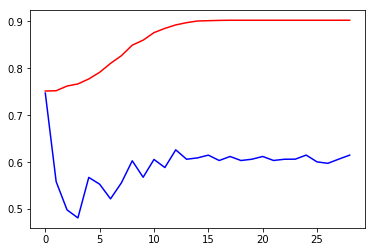

In [24]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

test_ACC, train_ACC = [], []
#train_F1, test_F1 = [], []
#train_J, test_J = [], []
hyperparams = np.arange(1, 30)
for hyperparam in hyperparams:
    test_acc, train_acc = [], []
    #test_f1, train_f1 = [], []
    #test_j, train_j = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        tree = DecisionTreeClassifier(criterion='entropy', max_depth = hyperparam).fit(X_train, y_train)
        y_hat_train = tree.predict(X_train)
        train_acc.append(metrics.accuracy_score(y_train, y_hat_train))
        #train_f1.append(f1_score(y_train, y_hat_train))
        #train_j.append(jaccard_score(y_train, y_hat_train))
        y_hat_test = tree.predict(X_test)
        test_acc.append(metrics.accuracy_score(y_test, y_hat_test))
        #test_f1.append(f1_score(y_test, y_hat_test))
        #test_j.append(jaccard_score(y_test, y_hat_test))
    train_ACC.append(np.mean(train_acc))
    #train_F1.append(np.mean(train_f1))
    #train_J.append(np.mean(train_j))
    test_ACC.append(np.mean(test_acc))
    #test_F1.append(np.mean(test_f1))
    #test_J.append(np.mean(test_j))
plt.plot(train_ACC, 'r')
plt.plot(test_ACC, 'b')
#plt.plot(train_F1, '--r')
#plt.plot(test_F1, '--b')
#plt.plot(train_J, '-.r')
#plt.plot(test_J, '-.b')

In [25]:
#based on visual interpretation, the best depth is 12
#now I train the model with using the whole X dataset
dt = DecisionTreeClassifier(criterion='entropy', max_depth = 12).fit(X, y)

# Support Vector Machine

In [26]:
from sklearn import svm

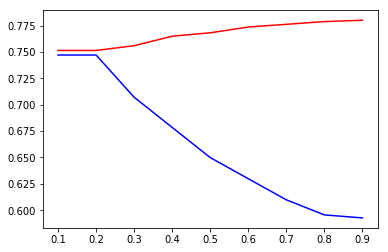

In [27]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

test_ACC, train_ACC = [], []
#test_F1, train_F1 = [], []
#test_J, train_J = [], []
hyperparams = np.arange(0.1, 1, 0.1)
for hyperparam in hyperparams:
    test_acc, train_acc = [], []
    #test_f1, train_f1 = [], []
    #test_j, train_j = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = svm.SVC(kernel = 'rbf', C = hyperparam).fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        train_acc.append(metrics.accuracy_score(y_train, y_hat_train))
        #train_f1.append(f1_score(y_train, y_hat_train))
        #train_j.append(jaccard_score(y_train, y_hat_train))
        y_hat_test = clf.predict(X_test)
        test_acc.append(metrics.accuracy_score(y_test, y_hat_test))
        #test_f1.append(f1_score(y_test, y_hat_test))
        #test_j.append(jaccard_score(y_test, y_hat_test))
    train_ACC.append(np.mean(train_acc))
    #train_F1.append(np.mean(train_f1))
    #train_J.append(np.mean(train_j))
    test_ACC.append(np.mean(test_acc))
    #test_F1.append(np.mean(test_f1))
    #test_J.append(np.mean(test_j))
plt.plot(hyperparams, train_ACC, 'r')
plt.plot(hyperparams, test_ACC, 'b')
#plt.plot(hyperparams, train_F1, '--r')
#plt.plot(hyperparams, test_F1, '--b')
#plt.plot(hyperparams, train_J, '-.r')
#plt.plot(hyperparams, test_J, '-.b')

In [28]:
#from visual interpretation, best C = 0.2
#now I train the model with using the whole X dataset
svc = svm.SVC(kernel = 'rbf', C = hyperparam).fit(X, y)

# Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

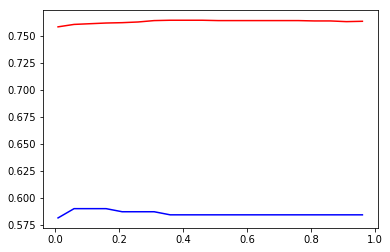

In [30]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

test_ACC, train_ACC = [], []
#test_F1, train_F1 = [], []
#test_J, train_J = [], []
hyperparams = np.arange(0.01, 1, 0.05)
for hyperparam in hyperparams:
    test_acc, train_acc = [], []
    #test_f1, train_f1 = [], []
    #test_j, train_j = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(C=hyperparam, solver='liblinear').fit(X_train,y_train)
        y_hat_train = clf.predict(X_train)
        train_acc.append(metrics.accuracy_score(y_train, y_hat_train))
        #train_f1.append(f1_score(y_train, y_hat_train))
        #train_j.append(jaccard_score(y_train, y_hat_train))
        y_hat_test = clf.predict(X_test)
        test_acc.append(metrics.accuracy_score(y_test, y_hat_test))
        #test_f1.append(f1_score(y_test, y_hat_test))
        #test_j.append(jaccard_score(y_test, y_hat_test))
    train_ACC.append(np.mean(train_acc))
    #train_F1.append(np.mean(train_f1))
    #train_J.append(np.mean(train_j))
    test_ACC.append(np.mean(test_acc))
    #test_F1.append(np.mean(test_f1))
    #test_J.append(np.mean(test_j))
plt.plot(hyperparams, train_ACC, 'r')
plt.plot(hyperparams, test_ACC, 'b')
#plt.plot(hyperparams, train_F1, '--r')
#plt.plot(hyperparams, test_F1, '--b')
#plt.plot(hyperparams, train_J, '-.r')
#plt.plot(hyperparams, test_J, '-.b')

In [31]:
#there is no significant change of performance as a function of C
#I choose C = 0.01 and train the model using the whole X data
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)

# Model Evaluation using Test set

Now, download and load the test set:

In [32]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-12-29 07:44:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3,6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3,56K  --.-KB/s    in 0s      

2020-12-29 07:44:20 (229 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [33]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [34]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

In [35]:
X_test = Feature_test
y_test = test_df['loan_status'].values
X_test= preprocessing.StandardScaler().fit(Feature).transform(X_test)
#it's a common mistake not to use .fit(Feature) but .fit(X_test) instead
X_test[0:5]

array([[ 0.51578458,  0.92071769,  3.16061891,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [-5.89052444, -1.96168647,  0.67333883, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.86968108],
       [ 0.51578458,  0.92071769,  1.9998882 ,  2.37778177,  0.82934003,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769, -0.81902922, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [-1.31458942, -0.95911111, -0.3215732 , -0.42056004,  0.82934003,
         2.61985426, -0.87997669, -0.86968108]])

In [36]:
knn_yhat = knn.predict(X_test)
dt_yhat = dt.predict(X_test)
svc_yhat = svc.predict(X_test)
lr_yhat = lr.predict(X_test)
lr_yhat_probs = lr.predict_proba(X_test)

In [37]:
print('knn Jaccard Score: ', jaccard_score(y_test, knn_yhat))
print('knn F1-score: , ', metrics.f1_score(y_test, knn_yhat))
print('-------')
print('Decision Tree Jaccard Score: ', jaccard_score(y_test, dt_yhat))
print('Decision Tree F1-score: ', metrics.f1_score(y_test, dt_yhat))
print('-------')
print('SVM Jaccard Score: ', jaccard_score(y_test, svc_yhat))
print('SVM F1-Score: ', metrics.f1_score(y_test, svc_yhat))
print('-------')
print('Logistic Regression Jaccard Score: ', jaccard_score(y_test, lr_yhat))
print('Logistic Regression F1-score: ', metrics.f1_score(y_test, lr_yhat))
print('Logistic Regression LogLoss: ', log_loss(y_test, lr_yhat_probs))

knn Jaccard Score:  0.7222222222222222
knn F1-score: ,  0.8314606741573034
-------
Decision Tree Jaccard Score:  0.6666666666666666
Decision Tree F1-score:  0.7692307692307692
-------
SVM Jaccard Score:  0.7222222222222222
SVM F1-Score:  0.8387096774193549
-------
Logistic Regression Jaccard Score:  0.7592592592592593
Logistic Regression F1-score:  0.8602150537634409
Logistic Regression LogLoss:  0.5563591871478355


# Report

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72    | 0.83     | NA      |
| Decision Tree      | 0.67    | 0.77     | NA      |
| SVM                | 0.72    | 0.83     | NA      |
| LogisticRegression | 0.76    | 0.86     | 0.56    |